In [39]:
import io
import re

import matplotlib.pyplot as plt
import pandas as pd

from wmfdata import hive, mariadb, charting

# Load Wikistats 1 article counts

In [10]:
# Pull Wikistats data files, removing old copies from previous runs
wikistats_files = "csv_*_main.zip"
wikistats_path = "/mnt/data/xmldatadumps/public/other/wikistats_1/"
!rm ../data/{wikistats_files}
!cp {wikistats_path}{wikistats_files} ../data

zipfiles = !ls ../data/csv_*_main.zip
cols = ["wiki", "group", "month", "articles", "files"]
content = pd.DataFrame(columns=cols)

for f in zipfiles:
    # Extract the Wikistats code for the project family
    grp = re.search(r"data/csv_([a-z]{2})_main.zip", f).group(1)
    
    # Map Wikistats codes for project family to the corresponding database codes
    db_suffix = {
        "wb": "wikibooks",
        "wk": "wiktionary",
        "wn": "wikinews",
        "wo": "wikivoyage",
        "wp": "wiki",
        "wq": "wikiquote",
        "ws": "wikisource",
        "wv": "wikiversity",
        "wx": ""
    }
    
    # Unzip files to stdout and capture it in an IPython SList.
    # Put the newline-separated string (`.n`) of the output in a buffer for Pandas.
    sm = !unzip -p {f} StatisticsMonthly.csv
    sm = io.StringIO(sm.n)
    
    spn = !unzip -p {f} StatisticsPerNamespace.csv
    spn = io.StringIO(spn.n)
     
    # Manually set column numbers because some CSVs are ragged 
    # Select the columns we need, which aren't named so we need to select by location
    art = pd.read_csv(sm, header=None, usecols=[0, 1, 6], names=range(29))
    art.columns = ["wiki", "month", "articles"]

    # Wikisource has extra namespaces so its file has more columns
    if grp == "ws":
        col_nums = range(22)
    else:
        col_nums = range(17)
    
    files = pd.read_csv(spn, header=None, usecols=[0, 1, 5], names=col_nums)
    files.columns = ["wiki", "month", "files"]
        
    grp_content = pd.merge(art, files, on=["wiki", "month"], validate="one_to_one")
        
    # Wiki column just contains the language code (except in wx) so we have to disambiguate across files
    grp_content["wiki"] = grp_content["wiki"] + db_suffix[grp]
    
    grp_content["group"] = grp
    
    content = content.append(grp_content, sort=False)
    
    sm.close()
    spn.close()

content["month"] = pd.to_datetime(content["month"])
content["articles"] = content["articles"].astype(int)

# Remove "wikis" with zz codes since those are aggregates
not_zz = lambda df: ~df["wiki"].str.match(r"zz.*")
content = content[not_zz]

content.tail()

,wiki,group,month,articles,files
1926,wikidata,wx,2018-04-30,48917104,0.0
1927,wikidata,wx,2018-05-31,50391825,0.0
1928,wikidata,wx,2018-06-30,50978404,0.0
1929,wikidata,wx,2018-07-31,51446133,0.0
1930,wikidata,wx,2018-08-31,51977456,0.0


In [16]:
ws_aug = content.query("group == 'wp' and month == '2018-08-31'")[["wiki", "articles"]].set_index("wiki")

In [29]:
ws_aug = ws_aug.rename(columns={"articles": "ws_articles"})

# Get mediawiki_history article counts

In [26]:
mh_aug = hive.run("""
select
    wiki_db as wiki,
    count(*) as mh_articles
from wmf.mediawiki_page_history
where
    snapshot = "2018-08" and
    page_namespace_is_content = true and
    page_is_redirect = false and
    end_timestamp is null
group by wiki_db
""")

In [30]:
mh_aug = mh_aug.set_index("wiki")

# Join counts

In [34]:
aug_articles = ws_aug.join(mh_aug).fillna(0)

In [37]:
aug_articles["mh_diff"] = (aug_articles["mh_articles"] / aug_articles["ws_articles"]) - 1

In [38]:
aug_articles

,ws_articles,mh_articles,mh_diff
wiki,,,
aawiki,2,0.0,-1.000000
abwiki,3479,3479.0,0.000000
acewiki,7522,7522.0,0.000000
afwiki,55818,55819.0,0.000018
akwiki,623,623.0,0.000000
alswiki,24909,24908.0,-0.000040
amwiki,14916,14916.0,0.000000
anwiki,33477,33477.0,0.000000
angwiki,3098,3098.0,0.000000


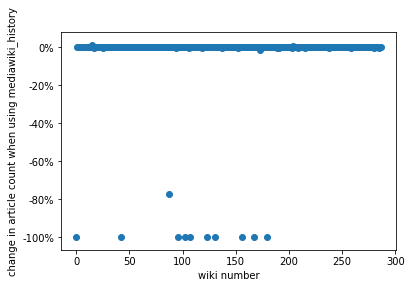

In [46]:
fig, ax = plt.subplots()
ax.set_xlabel("wiki number")
ax.set_ylabel("change in article count when using mediawiki_history")
ax.yaxis.set_major_formatter(charting.pct_fmt)

bars = ax.scatter(range(len(aug_articles["mh_diff"])), aug_articles["mh_diff"])

Other than the Gothic Wikipedia (gotwiki), these all seem to be wikis that are closed, so counting them as 0 is not a big deal.

In [49]:
aug_articles.query("abs(mh_diff) > 0.5")

,ws_articles,mh_articles,mh_diff
wiki,,,
aawiki,2,0.0,-1.000000
chowiki,14,0.0,-1.000000
gotwiki,692,159.0,-0.770231
howiki,4,0.0,-1.000000
hzwiki,1,0.0,-1.000000
iiwiki,15,0.0,-1.000000
kjwiki,6,0.0,-1.000000
krwiki,1,0.0,-1.000000
mhwiki,9,0.0,-1.000000


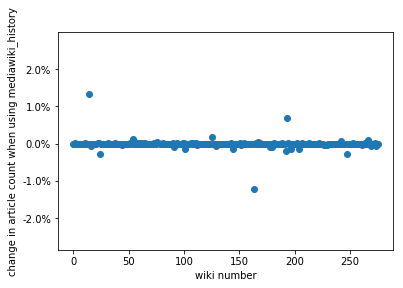

In [53]:
fig, ax = plt.subplots()
ax.set_xlabel("wiki number")
ax.set_ylabel("change in article count when using mediawiki_history")
ax.yaxis.set_major_formatter(charting.pct_fmt)

small_diffs = aug_articles.query("abs(mh_diff) < 0.5")

bars = ax.scatter(range(len(small_diffs["mh_diff"])), small_diffs["mh_diff"])

None of these seem concerning either.

In [57]:
small_diffs.query("abs(mh_diff) > 0.001")

,ws_articles,mh_articles,mh_diff
wiki,,,
avwiki,2387,2419.0,0.013406
bhwiki,7673,7652.0,-0.002737
diqwiki,9248,9258.0,0.001081
igwiki,1427,1425.0,-0.001402
kshwiki,2840,2845.0,0.001761
maiwiki,13885,13864.0,-0.001512
nahwiki,7187,7100.0,-0.012105
pntwiki,501,500.0,-0.001996
pswiki,9836,9903.0,0.006812
